# TP 2 : Classification non supervisée de textures

## Auteurs :
- BURGER Loan
- PETIT Lucas

## Date :
- 13/11/2023

## Done :
Découper les images en patchs

Faire l'histogramme des gradient sur toute nos données (gradient en noir et blanc)
   - Sobel en x et y sur le gradient
   - Tableaau de n valeurs pour les orientations
   - Pour chaque pixels la valeur est donnée par arc tan (y/x)

## TODO :
Matcher nos prédictions et labels ou mettre un label au cluster

Générer des textures et les classifier avec k_means

In [241]:
import random
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from collections import Counter


def get_cmap(n, name='hsv'):
    return plt.cm.get_cmap(name, n)

## Implémentation des algorithmes

In [242]:
def k_means(data, k, max_iterations):
    cluster_centers = []
    clusters = []
    iterations = 0

    for i in range(k):
        cluster_centers.append(data[i])

    for i in range(k):
        clusters.append([])

    for i in range(len(data)):
        distances = []
        for j in range(k):
            distances.append(np.linalg.norm(data[i] - cluster_centers[j]))
        clusters[distances.index(min(distances))].append(data[i])

    for i in range(k):
        cluster_centers[i] = np.mean(clusters[i], axis=0)

    while True and iterations < max_iterations:
        changed = False
        for i in range(len(data)):
            distances = []
            for j in range(k):
                distances.append(np.linalg.norm(data[i] - cluster_centers[j]))
            clusters[distances.index(min(distances))].append(data[i])

        for i in range(k):
            if not np.array_equal(cluster_centers[i], np.mean(clusters[i], axis=0)):
                changed = True
            cluster_centers[i] = np.mean(clusters[i], axis=0)

        if not changed:
            break

        iterations += 1

    return cluster_centers, clusters

In [243]:
def labeled_k_means(data, labels, k, max_iterations):
    cluster_centers = []
    clusters = []
    cluster_labels = []
    iterations = 0

    initial_indices = np.random.choice(len(data), k, replace=False)
    for i in initial_indices:
        cluster_centers.append(data[i])

    while True:
        changed = False
        new_clusters = [[] for _ in range(k)]
        new_cluster_labels = [[] for _ in range(k)]

        for i in range(len(data)):
            distances = [np.linalg.norm(data[i] - center) for center in cluster_centers]
            min_index = distances.index(min(distances))
            new_clusters[min_index].append(data[i])
            new_cluster_labels[min_index].append(labels[i])

        for i in range(k):
            if len(new_clusters[i]) == 0:  # Skip empty clusters
                continue
            new_center = np.mean(new_clusters[i], axis=0)
            if not np.array_equal(cluster_centers[i], new_center):
                changed = True
                cluster_centers[i] = new_center

        if not changed or iterations >= max_iterations:
            break

        clusters = new_clusters
        cluster_labels = new_cluster_labels
        iterations += 1

    return cluster_centers, clusters, cluster_labels


In [244]:
def predict(data, cluster_centers):
    predictions = []
    for i in range(len(data)):
        distances = []
        for j in range(len(cluster_centers)):
            distances.append(np.linalg.norm(data[i] - cluster_centers[j]))
        predictions.append(distances.index(min(distances)))

    return predictions

In [245]:
def predict_with_labels(data, cluster_centers, cluster_labels):
    predictions = []
    for point in data:
        distances = [np.linalg.norm(point - center) for center in cluster_centers]
        closest_cluster_index = distances.index(min(distances))
        if cluster_labels[closest_cluster_index]:
            most_common_label = Counter(cluster_labels[closest_cluster_index]).most_common(1)[0][0]
            predictions.append(most_common_label)
        else:
            predictions.append(None)

    return predictions

In [246]:
def train_test(filenames, patch_size):
    train_data = []
    test_data = []
    img_data = []
    for i in range(len(filenames)):
        sample_image = Image.open(filenames[i])
        sample_image_gray = sample_image.convert('L')
        np_sample_img = np.array(sample_image_gray)
        for x in range(0, np_sample_img.shape[0], patch_size):
            for y in range(0, np_sample_img.shape[1], patch_size):
                patch = np_sample_img[x:x + patch_size, y:y + patch_size]
                img_data.append((patch, filenames[i]))

    random.shuffle(img_data)
    half = int(len(img_data) / 2)
    train_data.append(img_data[:half])
    test_data.append(img_data[half:])

    return train_data, test_data

In [247]:
def gradient(img):
    img = np.array(img)
    img = img.astype('int32')
    sobel_x = np.array([[-1, 0, 1],
                        [-2, 0, 2],
                        [-1, 0, 1]])
    sobel_y = np.array([[-1, -2, -1],
                        [0, 0, 0],
                        [1, 2, 1]])

    gradient_x = np.zeros((img.shape[0], img.shape[1]))
    gradient_y = np.zeros((img.shape[0], img.shape[1]))

    for i in range(1, img.shape[0] - 1):
        for j in range(1, img.shape[1] - 1):
            gradient_x[i][j] = np.sum(img[i - 1:i + 2, j - 1:j + 2] * sobel_x)
            gradient_y[i][j] = np.sum(img[i - 1:i + 2, j - 1:j + 2] * sobel_y)

    return gradient_x, gradient_y

In [248]:
def HOG(img, n_bins):
    gradient_x, gradient_y = gradient(img)
    gradient_magnitude = np.sqrt(gradient_x ** 2 + gradient_y ** 2)
    gradient_orientation = np.arctan2(gradient_y, gradient_x)
    gradient_orientation = np.rad2deg(gradient_orientation)
    gradient_orientation[gradient_orientation < 0] += 180

    bins = np.linspace(0, 180, n_bins + 1)
    bins = bins.astype('int32')

    histogram = np.zeros(n_bins)

    for i in range(gradient_orientation.shape[0]):
        for j in range(gradient_orientation.shape[1]):
            for k in range(n_bins):
                if bins[k] <= gradient_orientation[i][j] < bins[k + 1]:
                    histogram[k] += gradient_magnitude[i][j]

    return histogram

  ## Classification des données 2D (GMM2D) en 5 classes

/tmp/ipykernel_15217/2975218052.py:9: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  return plt.cm.get_cmap(name, n)


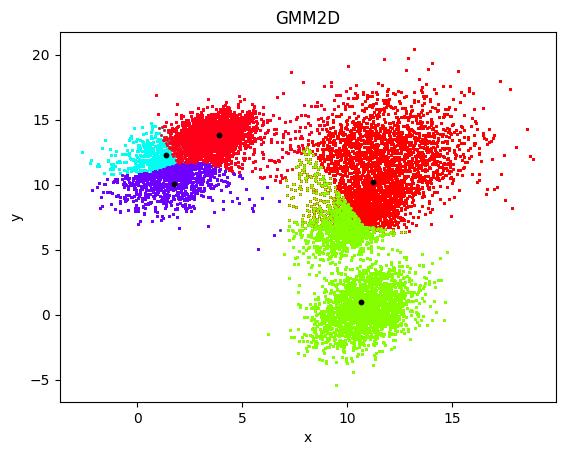

In [249]:
gmm2d = np.loadtxt("classif_data/gmm2d.asc")
centers, clusters = k_means(gmm2d, 5, 100)
cmap = get_cmap(len(clusters))

fig = plt.figure()
plt.title("GMM2D")
plt.xlabel("x")
plt.ylabel("y")
for i in range(len(clusters)):
    x = []
    y = []
    for j in range(len(clusters[i])):
        x.append(clusters[i][j][0])
        y.append(clusters[i][j][1])
    plt.scatter(x, y, s=1, color=cmap(i))

for i in range(len(centers)):
    plt.scatter(centers[i][0], centers[i][1], color='black', s=10)
plt.show()

  ## Classification des données 3D (GMM3D) en 5 classes

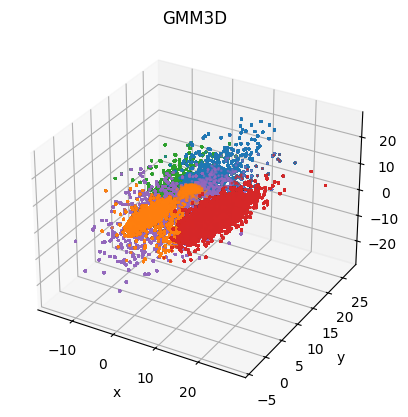

In [250]:
# Kmean GMM3D
gmm3d = np.loadtxt("classif_data/gmm3d.asc")
centers, clusters = k_means(gmm3d, 5, 100)

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
plt.title("GMM3D")
plt.xlabel("x")
plt.ylabel("y")
for i in range(len(clusters)):
    x = []
    y = []
    z = []
    for j in range(len(clusters[i])):
        x.append(clusters[i][j][0])
        y.append(clusters[i][j][1])
        z.append(clusters[i][j][2])
    ax.scatter(x, y, z, s=1)
plt.show()

## Découpages des images en patches (sans recouvrement)
Les l'ensemble des patchs et divisé en 2 pour optimiser la classification (train_data) et l’autre comme ensemble de test (test_data)

In [251]:
filenames = ["Colored_Brodatz/D1_COLORED.tif",
             "Colored_Brodatz/D2_COLORED.tif",
             "Colored_Brodatz/D28_COLORED.tif",
             "Colored_Brodatz/D45_COLORED.tif",
             "Colored_Brodatz/D40_COLORED.tif"]

train_data, test_data = train_test(filenames, 64)

nb_bins = 8

In [252]:
print(test_data[0][0][1])

Colored_Brodatz/D45_COLORED.tif


## Sauvegarde des patches (optionnel)

In [253]:
for i in range(len(train_data[0])):
    patch_img = Image.fromarray(train_data[0][i][0])
    patch_img.save("Patches/train{}_size64.png".format(i))

for i in range(len(test_data[0])):
    patch_img = Image.fromarray(test_data[0][i][0])
    patch_img.save("Patches/test{}_size64.png".format(i))

## Histogramme de gradients d'un patch (optionnel)

Patch label : Colored_Brodatz/D1_COLORED.tif
[64250.40710621 16290.42415605 10617.28940163 60344.26150308
 56806.61622754 11772.01961191 12817.08200999 43494.76639217]


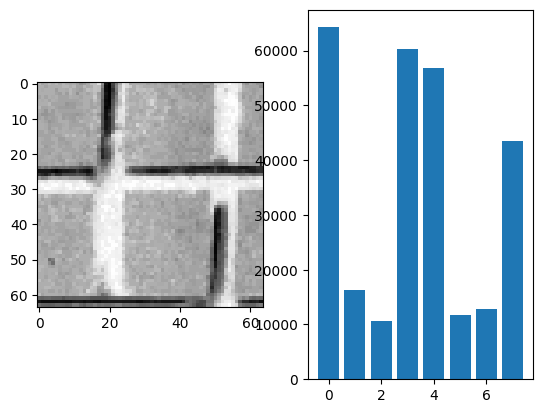

<Figure size 640x480 with 0 Axes>

In [254]:
tuple = train_data[0][0]

label = tuple[1]
print("Patch label : {}".format(label))

img = Image.fromarray(tuple[0])
img_gray = img.convert('L')
histogram = HOG(img_gray, nb_bins)
print(histogram)

#print image and histogram
fig = plt.figure()
ax = fig.add_subplot(1,2,1)
ax.imshow(img_gray, cmap='gray')
ax = fig.add_subplot(1,2,2)
ax.bar(np.arange(nb_bins), histogram)
plt.show()

## Calcul des histogrammes de gradients

In [255]:
train_histograms = []
train_labels = []
for i in range(len(train_data)):
    for j in range(len(train_data[i])):
        img = Image.fromarray(train_data[i][j][0])
        img_gray = img.convert('L')
        histogram = HOG(img_gray, nb_bins)
        train_histograms.append(histogram)
        train_labels.append(train_data[i][j][1])

## Classification des données de train avec les histogrammes de gradients

/tmp/ipykernel_15217/2975218052.py:9: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  return plt.cm.get_cmap(name, n)


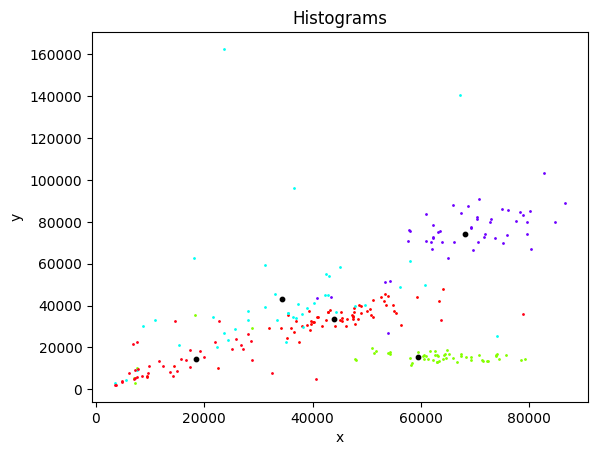

In [256]:
#centers, clusters = k_means(train_histograms, 5, 300)
centers, clusters, cluster_labels = labeled_k_means(train_histograms, train_labels, 5, 300)

cmap = get_cmap(len(clusters))

fig = plt.figure()
plt.title("Histograms")
plt.xlabel("x")
plt.ylabel("y")
for i in range(len(clusters)):
    x = []
    y = []
    for j in range(len(clusters[i])):
        x.append(clusters[i][j][0])
        y.append(clusters[i][j][1])
    plt.scatter(x, y, s=1, color=cmap(i))
    
for i in range(len(centers)):
    plt.scatter(centers[i][0], centers[i][1], color='black', s=10)
plt.show()

## Test du classifieur avec les données de train (on doit avoir 100% de réussite)

In [257]:
train_predictions = predict_with_labels(train_histograms, centers, cluster_labels)
correct = 0
for i in range(len(train_labels)):
    if train_predictions[i] == train_labels[i]:
        correct += 1
        
print("Accuracy : {}%".format(correct / len(train_predictions) * 100))

Accuracy : 80.4%


## Test du classifieur avec les données de test

In [258]:
test_histograms = []
test_labels = []
for i in range(len(test_data)):
    for j in range(len(test_data[i])):
        img = Image.fromarray(test_data[i][j][0])
        img_gray = img.convert('L')
        histogram = HOG(img_gray, nb_bins)
        test_histograms.append(histogram)
        test_labels.append(test_data[i][j][1])
        

In [259]:
test_predictions = predict_with_labels(test_histograms, centers, cluster_labels)

correct = 0
for i in range(len(test_labels)):
    if test_predictions[i] == test_labels[i]:
        correct += 1
        
print("Accuracy : {}%".format(correct / len(test_predictions) * 100))

Accuracy : 76.0%


## Test du classifieur avec les données générées

In [260]:
filepaths = ["Colored_Brodatz_Generated/D1_COLORED.png",
             "Colored_Brodatz_Generated/D2_COLORED.png",
             "Colored_Brodatz_Generated/D28_COLORED.png",
             "Colored_Brodatz_Generated/D45_COLORED.png",
             "Colored_Brodatz_Generated/D40_COLORED.png"]

filenames = ["Colored_Brodatz/D1_COLORED.tif",
             "Colored_Brodatz/D2_COLORED.tif",
             "Colored_Brodatz/D28_COLORED.tif",
             "Colored_Brodatz/D45_COLORED.tif",
             "Colored_Brodatz/D40_COLORED.tif"]

generated_data = []
patch_size = 64

for i in range(len(filepaths)):
    sample_image = Image.open(filepaths[i])
    sample_image_gray = sample_image.convert('L')
    np_sample_img = np.array(sample_image_gray)
    for x in range(0, np_sample_img.shape[0], patch_size):
        for y in range(0, np_sample_img.shape[1], patch_size):
            patch = np_sample_img[x:x + patch_size, y:y + patch_size]
            generated_data.append((patch, filenames[i]))

In [261]:
generated_histograms = []
generated_labels = []

for i in range(len(generated_data)):
    img = Image.fromarray(generated_data[i][0])
    img_gray = img.convert('L')
    histogram = HOG(img_gray, nb_bins)
    generated_histograms.append(histogram)
    generated_labels.append(generated_data[i][1])

In [262]:
generated_predictions = predict_with_labels(generated_histograms, centers, cluster_labels)

correct = 0
for i in range(len(generated_labels)):
    if generated_predictions[i] == generated_labels[i]:
        correct += 1

print("Accuracy : {}%".format(correct / len(generated_predictions) * 100))

Accuracy : 80.0%


## Test du classifieur avec les données générées floutées

In [263]:
filepaths = ["Colored_Brodatz_Generated_Blurred/D1_COLORED.tif",
             "Colored_Brodatz_Generated_Blurred/D2_COLORED.tif",
             "Colored_Brodatz_Generated_Blurred/D28_COLORED.tif",
             "Colored_Brodatz_Generated_Blurred/D45_COLORED.tif",
             "Colored_Brodatz_Generated_Blurred/D40_COLORED.tif"]

filenames = ["Colored_Brodatz/D1_COLORED.tif",
             "Colored_Brodatz/D2_COLORED.tif",
             "Colored_Brodatz/D28_COLORED.tif",
             "Colored_Brodatz/D45_COLORED.tif",
             "Colored_Brodatz/D40_COLORED.tif"]

generated_data = []
patch_size = 64

for i in range(len(filepaths)):
    sample_image = Image.open(filepaths[i])
    sample_image_gray = sample_image.convert('L')
    np_sample_img = np.array(sample_image_gray)
    for x in range(0, np_sample_img.shape[0], patch_size):
        for y in range(0, np_sample_img.shape[1], patch_size):
            patch = np_sample_img[x:x + patch_size, y:y + patch_size]
            generated_data.append((patch, filenames[i]))

In [264]:
generated_histograms = []
generated_labels = []

for i in range(len(generated_data)):
    img = Image.fromarray(generated_data[i][0])
    img_gray = img.convert('L')
    histogram = HOG(img_gray, nb_bins)
    generated_histograms.append(histogram)
    generated_labels.append(generated_data[i][1])

In [265]:
generated_predictions = predict_with_labels(generated_histograms, centers, cluster_labels)

correct = 0
for i in range(len(generated_labels)):
    if generated_predictions[i] == generated_labels[i]:
        correct += 1
        
print("Accuracy : {}%".format(correct / len(generated_predictions) * 100))

Accuracy : 40.0%
